## Линейная регрессия: переобучение и регуляризация  
**Постановка задачи**: построить линейную модель для прогнозирования количества прокатов велосипедов в зависимости от календарных характеристик дня и погодных условий. Нужно так подобрать веса признаков, чтобы уловить все линейные зависимости в данных и в то же время не учесть лишние признаки, тогда модель не переобучится и будет делать достаточно точные предсказания на новых данных. Найденные линейные зависимости нужно будет интерпретировать, то есть понять, соответствует ли обнаруженная закономерность здравому смыслу. Основная цель задания --- на примере показать и объяснить, из-за чего возникает переобучение и как с ним можно бороться.

In [0]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

## Знакомство с данными

In [80]:
df = pd.read_csv(r'https://d3c33hcgiwev3.cloudfront.net/_1fbbe0f3404552777e1932b2a209e803_bikes_rent.csv?Expires=1564531200&Signature=hJpasl5k-hbQwS67n-RTvgUUxafF~fCbDAwrlWPRfmKbILu-Z32H88IthkWRzzuY~YwFPTuv7xi5x2Kn0QEKkAhyIbUr0kE-TK5yZtx~AzyCchWqYcZSFAKe2154-hwMxdt~yAuRftw06w7Z51QGIwcc76cn~0QB5HlGN9nIa-0_&Key-Pair-Id=APKAJLTNE6QMUY6HBC5A')
df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,4.805490,985
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,7.443949,801
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,7.437060,1349
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,4.800998,1562
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,5.597810,1600


Для каждого дня проката известны следующие признаки (как они были указаны в источнике данных):

* season: 1 - весна, 2 - лето, 3 - осень, 4 - зима
* yr: 0 - 2011, 1 - 2012
* mnth: от 1 до 12
* holiday: 0 - нет праздника, 1 - есть праздник
* weekday: от 0 до 6
* workingday: 0 - нерабочий день, 1 - рабочий день
* weathersit: оценка благоприятности погоды от 1 (чистый, ясный день) до 4 (ливень, туман)
* temp: температура в Цельсиях
* atemp: температура по ощущениям в Цельсиях
* hum: влажность
* windspeed(mph): скорость ветра в милях в час
* windspeed(ms): скорость ветра в метрах в секунду
* cnt: количество арендованных велосипедов (это целевой признак, его мы будем предсказывать)  

Итак, у нас есть вещественные, бинарные и номинальные (порядковые) признаки, и со всеми из них можно работать как с вещественными. С номинальныеми признаками тоже можно работать как с вещественными, потому что на них задан порядок. Давайте посмотрим на графиках, как целевой признак зависит от остальных

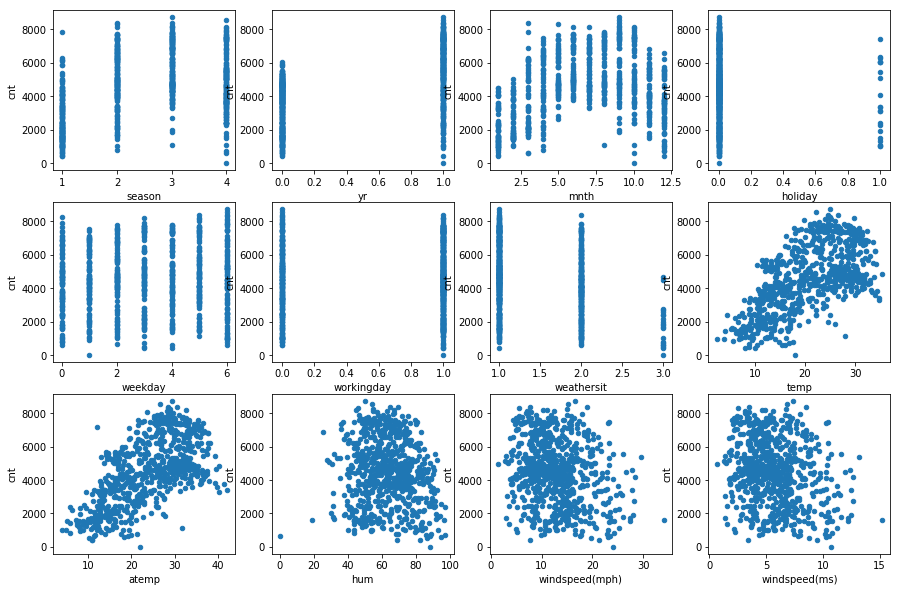

In [81]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15, 10))
for idx, feature in enumerate(df.columns[:-1]):
  df.plot(feature, "cnt", subplots=True, kind="scatter", ax=axes[int(idx/4), idx%4])

Доп вопросы:

**Блок 1**. Ответьте на вопросы (каждый 0.5 балла):

*Каков характер зависимости числа прокатов от месяца?*

Кваддратический, ось симетрии параболы приходится примерно на шестой-седьмой меяц. На графике можно увидеть рост продаж, который начинается весной, достигает пиков в летний период и идет на спад в начале осени

*Укажите один или два признака, от которых число прокатов скорее всего зависит линейно*

Явно видна линейная зависимость целевой переменной от обоих температурных признаков признаков  (temp и atemp), тем не менее наличие обоих в датафрейме избыточно и с точки зрения полезности их можно воспринимать как один

Более строго оценим уровень линейной зависимости между признаками и целевой переменной. Хорошей мерой линейной зависимости между двумя векторами является корреляция Пирсона.

In [82]:
for col in df.columns[:-1]:
  print(
      'Корреляция между целевой переменной и признаком {} составляет: {}'
  .format(col, df['cnt'].corr(df[col])))

Корреляция между целевой переменной и признаком season составляет: 0.4061003707986365
Корреляция между целевой переменной и признаком yr составляет: 0.5667097078680865
Корреляция между целевой переменной и признаком mnth составляет: 0.27997711221927124
Корреляция между целевой переменной и признаком holiday составляет: -0.06834771589248406
Корреляция между целевой переменной и признаком weekday составляет: 0.06744341241063045
Корреляция между целевой переменной и признаком workingday составляет: 0.061156063060520655
Корреляция между целевой переменной и признаком weathersit составляет: -0.2973912388346636
Корреляция между целевой переменной и признаком temp составляет: 0.6274940090334922
Корреляция между целевой переменной и признаком atemp составляет: 0.6310656998491815
Корреляция между целевой переменной и признаком hum составляет: -0.1006585621371552
Корреляция между целевой переменной и признаком windspeed(mph) составляет: -0.2345449974216702
Корреляция между целевой переменной и п

В выборке есть признаки, коррелирующие с целевым, а значит, задачу можно решать линейными методами.

По графикам видно, что некоторые признаки похожи друг на друга. Поэтому давайте также посчитаем корреляции между вещественными признаками.

In [83]:
attrs = [col for col in df.columns if df[col].dtype == np.float]
df[attrs + ['cnt']].corr()

,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
temp,1.000000,0.991702,0.126963,-0.157944,-0.157944,0.627494
atemp,0.991702,1.000000,0.139988,-0.183643,-0.183643,0.631066
hum,0.126963,0.139988,1.000000,-0.248489,-0.248489,-0.100659
windspeed(mph),-0.157944,-0.183643,-0.248489,1.000000,1.000000,-0.234545
windspeed(ms),-0.157944,-0.183643,-0.248489,1.000000,1.000000,-0.234545
cnt,0.627494,0.631066,-0.100659,-0.234545,-0.234545,1.000000


На диагоналях, как и полагается, стоят единицы. Однако в матрице имеются еще две пары сильно коррелирующих столбцов: temp и atemp (коррелируют по своей природе) и два windspeed (потому что это просто перевод одних единиц в другие). Далее мы увидим, что этот факт негативно сказывается на обучении линейной модели.

Напоследок посмотрим средние признаков (метод mean), чтобы оценить масштаб признаков и доли 1 у бинарных признаков.

In [84]:
bin_attrib = [col for col in df.columns if len(df[col].value_counts()) == 2]
df[bin_attrib].describe().loc['mean']

yr            0.500684
holiday       0.028728
workingday    0.683995
Name: mean, dtype: float64

Признаки имеют разный масштаб, значит для дальнейшей работы нам лучше нормировать матрицу объекты-признаки.

## Проблема первая: коллинеарные признаки

Итак, в наших данных один признак дублирует другой, и есть еще два очень похожих. Конечно, мы могли бы сразу удалить дубликаты, но давайте посмотрим, как бы происходило обучение модели, если бы мы не заметили эту проблему.

Для начала проведем масштабирование, или стандартизацию признаков: из каждого признака вычтем его среднее и поделим на стандартное отклонение. 

Кроме того, нужно перемешать выборку, это потребуется для кросс-валидации.

In [0]:
from sklearn.preprocessing import scale
from sklearn.utils import shuffle

df_shuffled = shuffle(df, random_state=123)
X = scale(df_shuffled[df_shuffled.columns[:-1]])
y = df_shuffled["cnt"]

Обучим линейную регрессию на наших данных и посмотрим на веса признаков.

In [0]:
from sklearn.linear_model import LinearRegression

In [0]:
lin_model = LinearRegression()
lin_model.fit(X, y)
weights = zip(lin_model.coef_, df.columns)

In [88]:
list(weights)

[(570.8675887934525, 'season'),
 (1021.9652921309369, 'yr'),
 (-141.30438378580345, 'mnth'),
 (-86.75613647415624, 'holiday'),
 (137.22482362623418, 'weekday'),
 (56.39056950314733, 'workingday'),
 (-330.2332887484121, 'weathersit'),
 (367.47338726750786, 'temp'),
 (585.5559979631937, 'atemp'),
 (-145.6063153911189, 'hum'),
 (12458200269331.953, 'windspeed(mph)'),
 (-12458200269530.414, 'windspeed(ms)')]

Чтобы понять, почему так произошло, вспомним аналитическую формулу, по которой вычисляются веса линейной модели в методе наименьших квадратов:

$w = (X^TX)^{-1} X^T y$.

Если в X есть коллинеарные (линейно-зависимые) столбцы, матрица $X^TX$ становится вырожденной, и формула перестает быть корректной. Чем более зависимы признаки, тем меньше определитель этой матрицы и тем хуже аппроксимация $Xw \approx y$. Такая ситуацию называют проблемой мультиколлинеарности, вы обсуждали ее на лекции.

С парой temp-atemp чуть менее коррелирующих переменных такого не произошло, однако на практике всегда стоит внимательно следить за коэффициентами при похожих признаках.  

Решение проблемы мультиколлинеарности состоит в регуляризации линейной модели. К оптимизируемому функционалу прибавляют L1 или L2 норму весов, умноженную на коэффициент регуляризации  α . В первом случае метод называется Lasso, а во втором --- Ridge. Подробнее об этом также рассказано в лекции.

Обучим регрессоры Ridge и Lasso с параметрами по умолчанию и убедитесь, что проблема с весами решилась.

In [0]:
from sklearn.linear_model import Lasso, Ridge

### L1 - регуляризация

In [90]:
lasso_regressor = Lasso()
lasso_regressor.fit(X, y)
list(zip(df.columns[:-1], lasso_regressor.coef_))

[('season', 560.2416160308869),
 ('yr', 1019.4634940657196),
 ('mnth', -128.73062703678752),
 ('holiday', -86.15278133371116),
 ('weekday', 137.34789390496314),
 ('workingday', 55.212370641356685),
 ('weathersit', -332.3698569623484),
 ('temp', 376.3632362096995),
 ('atemp', 576.5307935045503),
 ('hum', -144.1291550034858),
 ('windspeed(mph)', -197.13968940248557),
 ('windspeed(ms)', -2.8050167469807684e-08)]

### L2 - регуляризация

In [91]:
ridge_regressor = Ridge()
ridge_regressor.fit(X, y)
list(zip(df.columns[:-1], ridge_regressor.coef_))

[('season', 563.0645722520175),
 ('yr', 1018.9483787875301),
 ('mnth', -131.873320282477),
 ('holiday', -86.74609799709219),
 ('weekday', 138.0051111787191),
 ('workingday', 55.90311037506478),
 ('weathersit', -332.34978849907395),
 ('temp', 386.4578891919065),
 ('atemp', 566.3470470600686),
 ('hum', -145.07132729867178),
 ('windspeed(mph)', -99.25944108179063),
 ('windspeed(ms)', -99.25944115434177)]

Не сказал бы конечно что проблема решена

**Блок 2**. Поясните, каким образом введение регуляризации решает проблему с весами и мультиколлинеарностью.

Но в теории - в процессе регуляризации происходит штрафование за абсолютное значение суммы весов, что приводит к одновременной минимизации как ошибки, так и этого значения, в поисках оптимума должны быть отброшены слишком большие веса при условно равном качестве, решая таким образом проблему мультиколлинеарности


## Проблема вторая: неинформативные признаки


В отличие от L2-регуляризации, L1 обнуляет веса при некоторых признаках, пронаблюдаем, как меняются веса при увеличении коэффициента регуляризации  α  (в лекции коэффициент при регуляризаторе мог быть обозначен другой буквой).

In [0]:
alphas = np.arange(1, 500, 50)
coefs_lasso = np.zeros((alphas.shape[0], X.shape[1])) 
coefs_ridge = np.zeros((alphas.shape[0], X.shape[1]))


def train(regressor_creator, result_matrix):
    for row_index, row in enumerate(result_matrix):
        regressor = regressor_creator(alphas[row_index])
        regressor.fit(X, y)
        for i, _ in enumerate(row):
            row[i] = regressor.coef_[i]

            
            
train(lambda alpha: Lasso(alpha=alpha), coefs_lasso)
train(lambda alpha: Ridge(alpha=alpha), coefs_ridge)

Визуализируем динамику весов при увеличении параметра регуляризации:

Text(0.5, 1.0, 'Ridge')

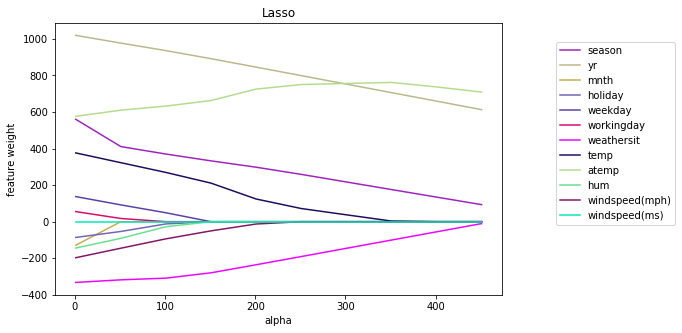

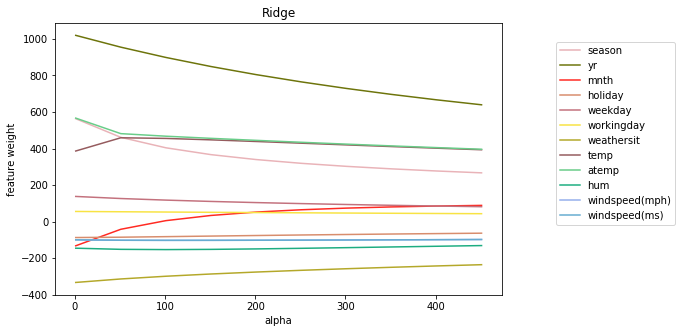

In [94]:
plt.figure(figsize=(8, 5))
for coef, feature in zip(coefs_lasso.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))
plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Lasso")

plt.figure(figsize=(8, 5))
for coef, feature in zip(coefs_ridge.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))
plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Ridge")

Ответы на следующие вопросы можно давать, глядя на графики или выводя коэффициенты на печать.

**Блок 3**. Ответьте на вопросы (каждый 0.25 балла):

*Какой регуляризатор (Ridge или Lasso) агрессивнее уменьшает веса при одном и том же alpha?*  
Lasso  

*Что произойдет с весами Lasso, если alpha сделать очень большим? Поясните, почему так происходит.*
 
Увеличение альфа приводит к более сильному штрафованию значения весов, что в свою очередь не позволит достичь оптимального качества по причине того что слагамое, отвечающее за регуляризацию, будет сильно больше среднеквадратичной ошибки, а оптимальное значение этого слагаемого достигается при нулевых весах.

*Можно ли утверждать, что Lasso исключает один из признаков windspeed при любом значении alpha > 0? А Ridge? Ситается, что регуляризатор исключает признак, если коэффициент при нем < 1e-3.*

Верно, вне зависимости от значения alpha вес признака windspeed(ms) близок к нулю что практически тождествленно игнорированию, в случае же с Ridge-регуляризацией оба признака windspeed имеют значения отличные от нуля

*Какой из регуляризаторов подойдет для отбора неинформативных признаков?*
Lasso, даже на предыдущем примере видна агрессивная политика, сводящаяся к исключению подобных признаков путем уменьшения их весов до нуля

Далее будем работать с Lasso.

Итак, мы видим, что при изменении alpha модель по-разному подбирает коэффициенты признаков. Нам нужно выбрать наилучшее alpha.

Для этого, во-первых, нам нужна метрика качества. Будем использовать в качестве метрики сам оптимизируемый функционал метода наименьших квадратов, то есть Mean Square Error.

Во-вторых, нужно понять, на каких данных эту метрику считать. Нельзя выбирать alpha по значению MSE на обучающей выборке, потому что тогда мы не сможем оценить, как модель будет делать предсказания на новых для нее данных. Если мы выберем одно разбиение выборки на обучающую и тестовую (это называется holdout), то настроимся на конкретные "новые" данные, и вновь можем переобучиться. Поэтому будем делать несколько разбиений выборки, на каждом пробовать разные значения alpha, а затем усреднять MSE. Удобнее всего делать такие разбиения кросс-валидацией, то есть разделить выборку на K частей, или блоков, и каждый раз брать одну из них как тестовую, а из оставшихся блоков составлять обучающую выборку.

Делать кросс-валидацию для регрессии в sklearn совсем просто: для этого есть специальный регрессор, LassoCV, который берет на вход список из alpha и для каждого из них вычисляет MSE на кросс-валидации. После обучения (если оставить параметр cv=3 по умолчанию) регрессор будет содержать переменную mse_path_, матрицу размера len(alpha) x k, k = 3 (число блоков в кросс-валидации), содержащую значения MSE на тесте для соответствующих запусков. Кроме того, в переменной alpha_ будет храниться выбранное значение параметра регуляризации, а в coef_, традиционно, обученные веса, соответствующие этому alpha_.

Обратите внимание, что регрессор может менять порядок, в котором он проходит по alphas; для сопоставления с матрицей MSE лучше использовать переменную регрессора alphas_.

In [0]:
from sklearn.linear_model import LassoCV

best alpha_: 6


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


[('season', 532.018982841354),
 ('yr', 1015.0602226430597),
 ('mnth', -100.03952614356668),
 ('holiday', -83.2939598752991),
 ('weekday', 132.50446549095787),
 ('workingday', 51.55708561407389),
 ('weathersit', -330.5598567399812),
 ('temp', 370.6798550300362),
 ('atemp', 581.3969310654958),
 ('hum', -140.00740550068878),
 ('windspeed(mph)', -191.77140847135155),
 ('windspeed(ms)', -2.6853782866626636e-08)]

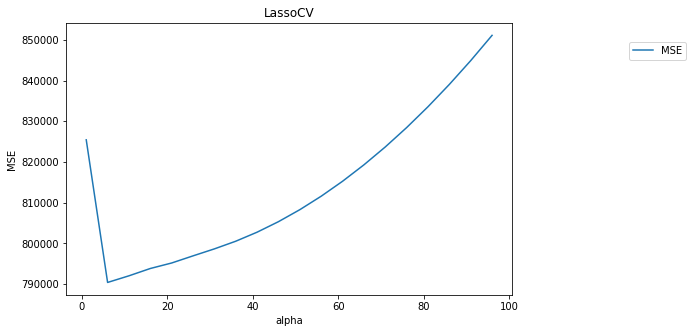

In [98]:
alphas = np.arange(1, 100, 5)
lassocv_regressor = LassoCV(alphas=alphas)
lassocv_regressor.fit(X, y)
mse_path = lassocv_regressor.mse_path_
regressor_alphas = lassocv_regressor.alphas_
mse_results = [np.mean(row) for row in mse_path]

plt.figure(figsize=(8, 5))
plt.plot(regressor_alphas, mse_results, label="MSE")
plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("MSE")
plt.title("LassoCV")

print("best alpha_: {}".format(lassocv_regressor.alpha_))

list(zip(df.columns[:-1], lassocv_regressor.coef_))

Итак, мы выбрали некоторый параметр регуляризации. Давайте посмотрим, какие бы мы выбирали alpha, если бы делили выборку только один раз на обучающую и тестовую, то есть рассмотрим траектории MSE, соответствующие отдельным блокам выборки.

MSE min alpha values [41  6  1]


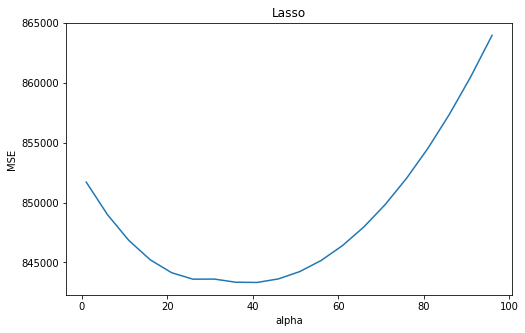

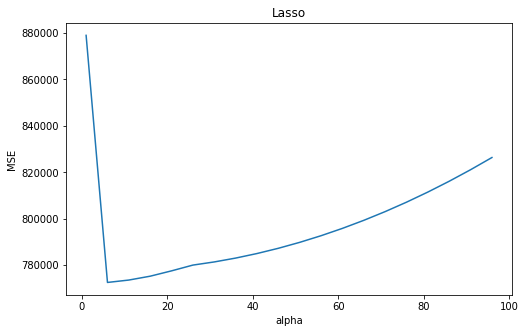

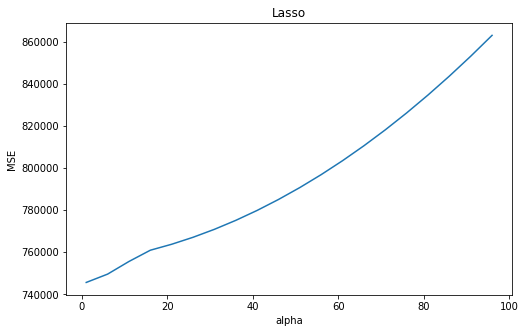

In [99]:
print('MSE min alpha values', 
      lassocv_clf.alphas_[np.argmin(lassocv_clf.mse_path_, axis = 0)])


for i in range(lassocv_clf.mse_path_.shape[1]):
    plt.figure(figsize=(8, 5))
    plt.plot(lassocv_clf.alphas_, lassocv_clf.mse_path_[:, i])
    plt.xlabel('alpha')
    plt.ylabel('MSE')
    plt.title('Lasso')
    plt.show()

На каждом разбиении оптимальное значение alpha свое, и ему соответствует большое MSE на других разбиениях. Получается, что мы настраиваемся на конкретные обучающие и контрольные выборки. При выборе alpha на кросс-валидации мы выбираем нечто "среднее", что будет давать приемлемое значение метрики на разных разбиениях выборки.

Наконец, как принято в анализе данных, давайте проинтерпретируем результат.

**Блок 4. ** Ответьте на вопросы

*В последней обученной модели выберите 4 признака с наибольшими (положительными) коэфициентами (и выпишите их), посмотрите на визуализации зависимостей cnt от этих признаков, которые мы рисовали в блоке "Знакомство с данными". Видна ли возрастающая линейная зависимость cnt от этих признаков по графикам? Логично ли утверждать (из здравого смысла), что чем больше значение этих признаков, тем больше людей захотят взять велосипеды?*

 * yr - год: ожидаемая положительная тенденция роста со временем
 * atemp - очевидно, что рост температуры является благоприятным фактором 
 * season - время года: если смотреть на график, то с весны по осень наблюдается возрастающая линейная зависимость,  однако, зимой количество прокатов падает, что в принципе связано с температурой
 * temp - температура: аналогично с atemp
 
 Выберите 3 признака с наибольшими по модулю отрицательными коэффициентами (и выпишите их), посмотрите на соответствующие визуализации. Видна ли убывающая линейная зависимость? Логично ли утверждать, что чем больше величина этих признаков, тем меньше людей захотят взять велосипеды *italicized text*?  
 
  * weathersit - погода (1 - хорошая, 4 - очень плохая)
 * windspeed(mph) - скорость ветра
 * hum - влажность
 
Для всех этих показателей видна убывающая линейная зависимость и логично утверждать, что чем хуже погода (в том числе выше скорость ветра и влажность), тем меньше людей хотят покататься на велосипедах.

*Выпишите признаки с нулевыми коэффициентами. Как вы думаете, почему модель исключила их из модели (вновь посмотрите на графики)? Верно ли, что они никак не влияют на спрос на велосипеды?*  

Есть 2 признака с почти нулевыми коэффициентами windspeed(ms) и mnth. Признак windspeed(ms) по сути дублирует информацию в переменной windspeed(mph) (просто другие единицы измерения) и поэтому не несет пользы для модели и имеет нулевой вес. Логично, что заинтересованность людей в велосипедах зависит от месяца, но модель не учитывает этот признак, поскольку он несет немного дополнительной информации по сравнению с переменной season (месяц не так важен, как сезон).